In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import permutation_test, ttest_1samp, bootstrap
from statsmodels.regression.linear_model import OLS
df = pd.read_excel('../data/processed/final_melted_df_excel_paired_ALL.xlsx')
df

,paper_id,model_id,apa_citation,year,N,output_arousal,accuracy_arousal,output_valence,accuracy_valence,ML_model
0,20,130-1,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,24,"HA, LA",55.94,"HV, LV",54.73,class_Support Vector Machine (SVM) Lineal
1,20,130-2,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,24,"HA, LA",53.14,"HV, LV",55.78,class_Support Vector Machine (SVM) Polynomial
2,20,130-3,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2016,24,"HA, LA",62.23,"HV, LV",50.52,class_Support Vector Machine (SVM) Gaussian
3,23,147-1,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...",2016,32,"HA, LA",70.78,"HV, LV",69.60,class_Tree based models 10x63 No -Conv
4,23,147-2,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...",2016,32,"HA, LA",71.53,"HV, LV",70.54,class_Tree based models 10x21 No -Conv
...,...,...,...,...,...,...,...,...,...,...
151,174,76,"Liu, Y., Jia, Z., & Wang, H. (2023, October). ...",2023,32,HA; LA,56.86,HV; LV,59.56,Transformer
152,182,77,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,32,HA; LA,70.00,HV; LV,71.10,logistic_regression
153,182,78,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,32,HA; LA,79.10,HV; LV,78.20,logistic_regression
154,182,79,"Elalamy, R., Fanourakis, M., & Chanel, G. (202...",2021,32,HA; LA,64.60,HV; LV,65.30,logistic_regression


In [32]:
paper_id_to_citation = {
    20: "Wiem & Lachiri, 2017",
    23: "Ayata et al., 2017",
    32: "Siddharth et al., 2018",
    38: "Ayata et al., 2017",
    63: "Sharma et al., 2019",
    66: "Ganapathy et al., 2020",
    74: "Chang et al., 2019",
    82: "Santamaria-Granados et al., 2018",
    86: "Ganapathy & Swaminathan, 2020",
    91: "Susanto et al., 2020",
    94: "Yin et al., 2019",
    97: "Ganapathy & Swaminathan, 2019",
    109: "Bota et al., 2023",
    113: "Selvi & Vijayakumaran, 2023",
    116: "Jung & Sejnowski, 2019",
    117: "Saffaryazdi et al., 2024",
    129: "Ganapathy et al., 2021",
    131: "Pidgeon et al., 2022",
    133: "Dessai & Virani, 2023",
    135: "Gahlan & Sethia, 2024",
    138: "Chen et al., 2022",
    139: "Mu et al., 2024",
    142: "Perry Fordson et al., 2022",
    145: "Zhu et al., 2023",
    150: "Yin et al., 2022",
    154: "Joo et al., 2024",
    156: "Raheel et al., 2021",
    157: "Veeranki et al., 2024",
    161: "Shukla et al., 2019",
    162: "Chatterjee et al., 2022",
    163: "Tabbaa et al., 2021",
    166: "Gohumpu et al., 2023",
    171: "Singh et al., 2023",
    173: "Kumar & Fredo, 2025",
    174: "Liu et al., 2023",
    182: "Elalamy et al., 2021"
}


In [33]:
df['diff_acc'] = df['accuracy_arousal'] - df['accuracy_valence']

df['mean_acc'] = np.mean([df['accuracy_arousal'], df['accuracy_valence']], axis=0)

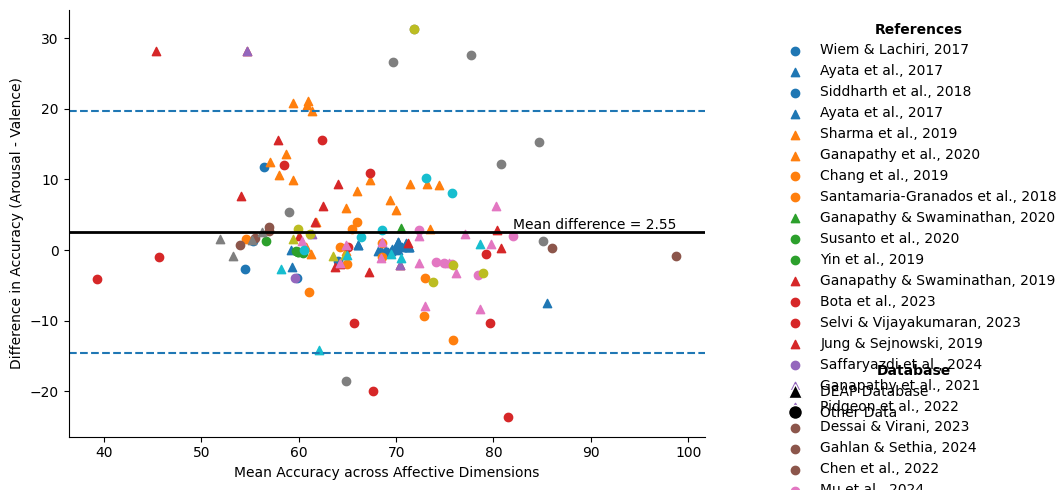

In [34]:
from scipy.stats import linregress  # Add this line
import seaborn as sns

# Unique paper IDs
unique_paper_ids = df['paper_id'].unique()

# Create a color map for paper IDs
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_paper_ids)))

plt.figure(figsize=(15, 5))

# Calculate the mean difference in accuracy
mean_diff_acc = np.mean(df['diff_acc'])

# Add a horizontal line to represent the mean difference in accuracy
plt.axhline(mean_diff_acc, color='black', linestyle='-', linewidth=2)

# Add text to indicate the mean value
plt.text(max(df['mean_acc']) * 1, mean_diff_acc, f'Mean difference = {mean_diff_acc:.2f}', verticalalignment='bottom', horizontalalignment='right')


# Calculate the correlation coefficient and p-value
slope, intercept, r_value, p_value, std_err = linregress(df['mean_acc'], df['diff_acc'])

for i, paper_id in enumerate(unique_paper_ids):
    subset = df[df['paper_id'] == paper_id]
    
    # Check if N == 32 for the subset
    is_N_32 = subset['N'] == 32
    
    # Get the citation for the paper ID
    citation = paper_id_to_citation.get(paper_id, f"Paper ID {paper_id}")
    
    # Plot points with N == 32 using triangles
    if any(is_N_32):
        plt.scatter(subset['mean_acc'][is_N_32], subset['diff_acc'][is_N_32], 
                    color=colors[i], marker='^', label=f"{citation}")
    
    # Plot other points using circles
    if any(~is_N_32):
        plt.scatter(subset['mean_acc'][~is_N_32], subset['diff_acc'][~is_N_32], 
                    color=colors[i], label=citation)

# Adding horizontal lines
plt.axhline(np.mean(df['diff_acc']) + 1.96 * np.std(df['diff_acc']), linestyle='--')
plt.axhline(np.mean(df['diff_acc']) - 1.96 * np.std(df['diff_acc']), linestyle='--')

# Adding labels and title
plt.xlabel('Mean Accuracy across Affective Dimensions')
plt.ylabel('Difference in Accuracy (Arousal - Valence)')
#plt.title('Mean vs Difference in Arousal and Valence Accuracy', fontweight='bold')

# Adding legend
legend1 = plt.legend(title='References',  bbox_to_anchor=(1.1, 1), loc='upper left', frameon=False, fancybox=True)
plt.gca().add_artist(legend1)
plt.setp(legend1.get_title(), weight='bold')

# Adding a second legend for marker types
legend2 = plt.legend([plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=10),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)],
                     ['DEAP Database                           ',
                       'Other Data                             '],
                       title='Database', bbox_to_anchor=(1.1, 0.2), loc='upper left',
                      frameon=False, fancybox=True)
plt.setp(legend2.get_title(), weight='bold')


plt.tight_layout(rect=[0, 0, 0.75, 1])

sns.despine()

# Show the plot
plt.show()

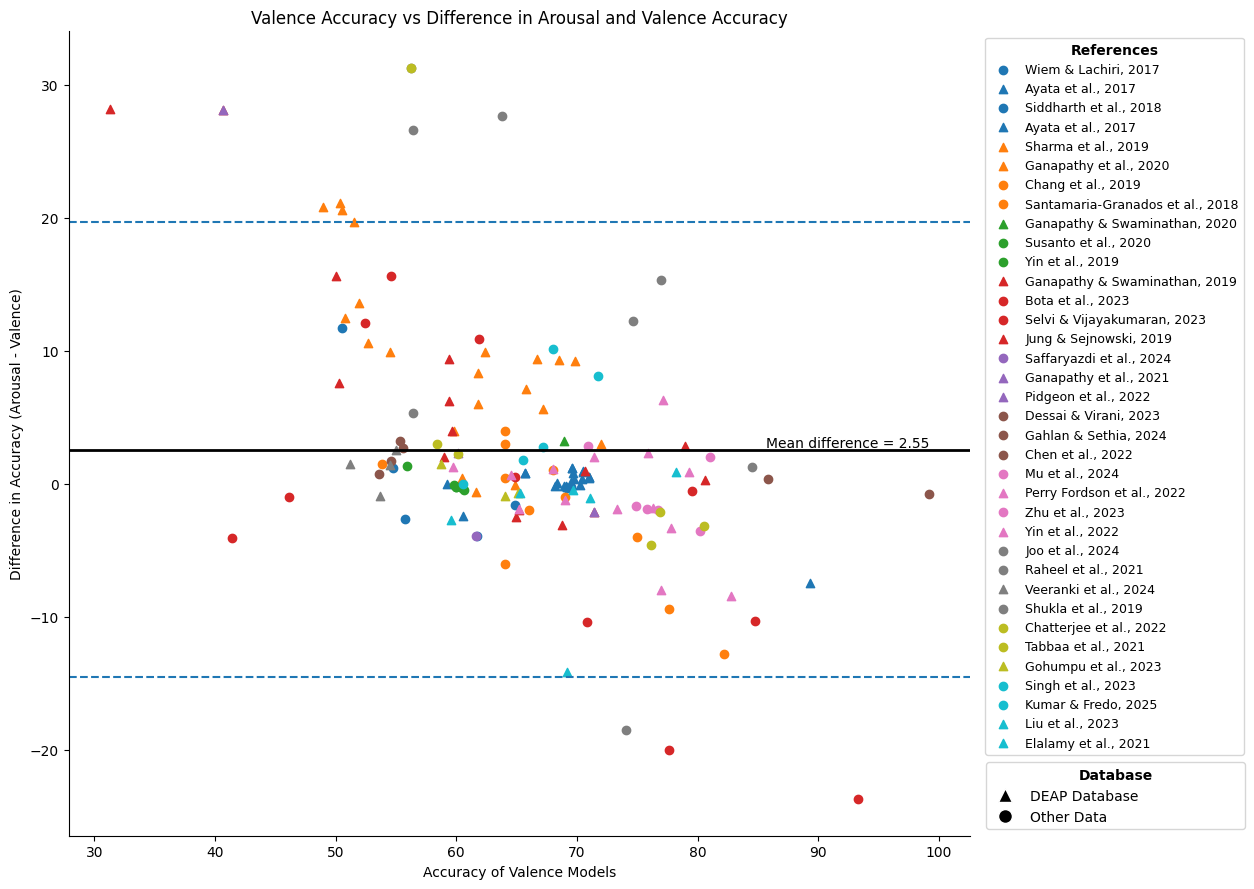

In [90]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration (replace with your actual DataFrame)
# import pandas as pd
# df = pd.DataFrame({
#     'paper_id': [...],
#     'N': [...],
#     'accuracy_arousal': [...],
#     'accuracy_valence': [...]
# })

# Calculate the difference in accuracy
df['diff_acc'] = df['accuracy_arousal'] - df['accuracy_valence']

# Unique paper IDs
unique_paper_ids = df['paper_id'].unique()

# Create a color map for paper IDs
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_paper_ids)))

plt.figure(figsize=(22, 9))  # Significantly increased width to accommodate the legend

# Calculate the mean difference in accuracy
mean_diff_acc = np.mean(df['diff_acc'])

# Add a horizontal line to represent the mean difference in accuracy
plt.axhline(mean_diff_acc, color='black', linestyle='-', linewidth=2)

# Add text to indicate the mean value
plt.text(max(df['accuracy_valence']) * 1, mean_diff_acc, f'Mean difference = {mean_diff_acc:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Calculate the correlation coefficient and p-value
slope, intercept, r_value, p_value, std_err = linregress(df['accuracy_valence'], df['diff_acc'])

for i, paper_id in enumerate(unique_paper_ids):
    subset = df[df['paper_id'] == paper_id]
    
    # Check if N == 32 for the subset
    is_N_32 = subset['N'] == 32
    
    # Get the citation for the paper ID
    citation = paper_id_to_citation.get(paper_id, f"Paper ID {paper_id}")
    
    # Plot points with N == 32 using triangles
    if any(is_N_32):
        plt.scatter(subset['accuracy_valence'][is_N_32], subset['diff_acc'][is_N_32], 
                    color=colors[i], marker='^', label=f"{citation}")
    
    # Plot other points using circles
    if any(~is_N_32):
        plt.scatter(subset['accuracy_valence'][~is_N_32], subset['diff_acc'][~is_N_32], 
                    color=colors[i], label=citation)

# Adding horizontal lines
plt.axhline(np.mean(df['diff_acc']) + 1.96 * np.std(df['diff_acc']), linestyle='--')
plt.axhline(np.mean(df['diff_acc']) - 1.96 * np.std(df['diff_acc']), linestyle='--')

# Adding labels and title
plt.xlabel('Accuracy of Valence Models')
plt.ylabel('Difference in Accuracy (Arousal - Valence)')
plt.title('Valence Accuracy vs Difference in Arousal and Valence Accuracy')

# Adjust the layout to maintain the plot size
plt.tight_layout(rect=[0, 0, 0.45, 1])  # Adjusted to leave about 1/3 of figure width for legends

# Get handles and labels for the references
handles, labels = plt.gca().get_legend_handles_labels()

# Single legend for all references with increased font size for better readability
legend1 = plt.legend(handles, labels, title='References', 
                    bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, 
                    fontsize=9, title_fontsize=10)
plt.gca().add_artist(legend1)
plt.setp(legend1.get_title(), weight='bold')

# Legend for marker types
legend3 = plt.legend([plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=10),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)],
                     ['DEAP Database                       ', 'Other Data'], 
                     title='Database', 
                     bbox_to_anchor=(1.01, 0.1), loc='upper left')
plt.setp(legend3.get_title(), weight='bold')

# Remove spines
sns.despine()

# Show the plot
plt.show()

In [19]:
x = df['diff_acc']

In [20]:
x

0       1.21
1      -2.64
2      11.71
3       1.18
4       0.99
       ...  
151    -2.70
152    -1.10
153     0.90
154    -0.70
155    -0.50
Name: diff_acc, Length: 156, dtype: float64

In [21]:
np.mean(x)

np.float64(2.551217948717949)

In [22]:
def my_stat(x):
    return ttest_1samp(x, popmean=0).statistic

In [23]:
permutation_test((x.values,), my_stat, permutation_type='samples')

PermutationTestResult(statistic=np.float64(3.642889990779817), pvalue=np.float64(0.0008), null_distribution=array([ 0.24558501,  0.18898442,  0.01994169, ..., -1.42510383,
       -0.61595724, -1.18576545], shape=(9999,)))

## Interpretación del resultado de la prueba de permutación

El resultado muestra una prueba de permutación que evalúa si la diferencia entre precisión de arousal y valencia (diff_acc) es significativamente diferente de cero:
Estadístico de prueba: 3.64 (valor t de la prueba t de una muestra)
Valor p: 0.0004 (muy pequeño, < 0.05)
Distribución nula: Generada mediante 9999 permutaciones aleatorias
La interpretación es que hay una diferencia estadísticamente significativa (p=0.0004) entre la precisión de arousal y valencia. Como el valor del estadístico es positivo y sabiendo que la media de diff_acc es 2.55 (de la celda 8), podemos concluir que la precisión de arousal es significativamente mayor que la de valencia en los modelos analizados.

In [24]:
permutation_test((x.values,), my_stat, permutation_type='samples')

PermutationTestResult(statistic=np.float64(3.642889990779817), pvalue=np.float64(0.0004), null_distribution=array([ 0.31838006, -1.61156641, -2.15478258, ..., -0.05086485,
        1.47602151,  0.31626963], shape=(9999,)))

In [25]:
bootstrap((x.values,), my_stat)

BootstrapResult(confidence_interval=ConfidenceInterval(low=np.float64(1.7763801486335409), high=np.float64(5.293461333026421)), bootstrap_distribution=array([3.20899861, 3.50846154, 3.92121606, ..., 4.72953626, 2.80466982,
       2.36422202], shape=(9999,)), standard_error=np.float64(0.893078090770869))

In [26]:
X = df[['N', 'year', 'mean_acc']]
X = sm.add_constant(X)


In [27]:
y = df['diff_acc']

In [28]:
model = OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_acc   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.539
Date:                Mon, 05 May 2025   Prob (F-statistic):             0.0587
Time:                        22:47:58   Log-Likelihood:                -555.36
No. Observations:                 156   AIC:                             1119.
Df Residuals:                     152   BIC:                             1131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -407.2840    547.170     -0.744      0.458   -1488.325     673.757
N             -0.0112      0.009     -1.306      0.193      -0.028       0.006
year           0.2098      0.271      0.774      0.440      -0.326       0.745
mean_acc      -0.2016      0.080     -2.525      0.013      -0.359      -0.044
==============================================================================
Omnibus:                       31.416   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.985
Skew:                           0.892   Prob(JB):                     7.74e-15
Kurtosis:                       5.611   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
rlm_mod = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_res = rlm_mod.fit()
rlm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               diff_acc   No. Observations:                  156
Model:                            RLM   Df Residuals:                      152
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 May 2025                                         
Time:                        22:47:58                                         
No. Iterations:                    19                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -97.4201    313.848     -0.310      0.756    -712.551     517.711
N             -0.0059      0.005     -1.206      0.228      -0.016       0.004
year           0.0527      0.155      0.339      0.735      -0.252       0.357
mean_acc      -0.1107      0.046     -2.417      0.016      -0.200      -0.021
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""